## Table of Contents

- [Prework](#Prework)
    - [Visualisaton for IV and HV](#Visualisaton_for_IV_and_HV)
        - [Summary statistics](#Summary_statistics)
        - [Data visualization](#Data_visualization)
        - [Stationarity check](#Stationarity_check)
        - [Performance metrics](#Performance_metrics)

- [Build Model](#Build_Model)
    - [Split trainning and testing dataset using VIX](#Split_trainning_and_testing_dataset_using_VIX)
    - [Benchmark - Multi-Layer Perceptron (MLP)](#Benchmark_Multi-Layer_Perceptron_(MLP))
    - [Build the ARIMA model using IV](#Build_the_ARIMA_model_using_IV)
    - [Build ANN model - LSTM](#Build_ANN_model_LSTM)
    - [Build ANN model - GRU](#Build_ANN_model_GRU)
    - [Build LSTM-ARIMA model](#Build_LSTM-ARIMA_model)
    - [Build ARIMA-LSTM model](#Build_ARIMA-LSTM_model)
    - [Build GRU-ARIMA model](#Build_GRU-ARIMA_model)
    - [Build ARIMA-GRU model](#Build_ARIMA-GRU_model)

- [Strategies](#Strategies)
    - [Combine models prediction results](#Combine_models_prediction_results)
    - [Evaluation method: index metrics](#Evaluation_method_index_metrics)


## Prework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from scipy.optimize import minimize
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.descriptivestats import describe
from statsmodels.tsa.stattools import adfuller as adf
import tensorflow as tf
import random as rn
import os
from scipy.stats import norm
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import arch
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import GridSearchCV
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math
from scipy.stats import norm
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
#Import data from downloaded excel files
india_file_path = r"F:\下载\dissertation\India.xlsx"

India = pd.read_excel(india_file_path, index_col="Date")


### Visualisaton_for_IV_and_HV

#### Summary_statistics

In [3]:
print(India['Price'].describe())

count    4021.000000
mean       20.486503
std         9.281598
min        10.135000
25%        14.610000
50%        17.717500
75%        22.902500
max        85.130000
Name: Price, dtype: float64


#### Data_visualization

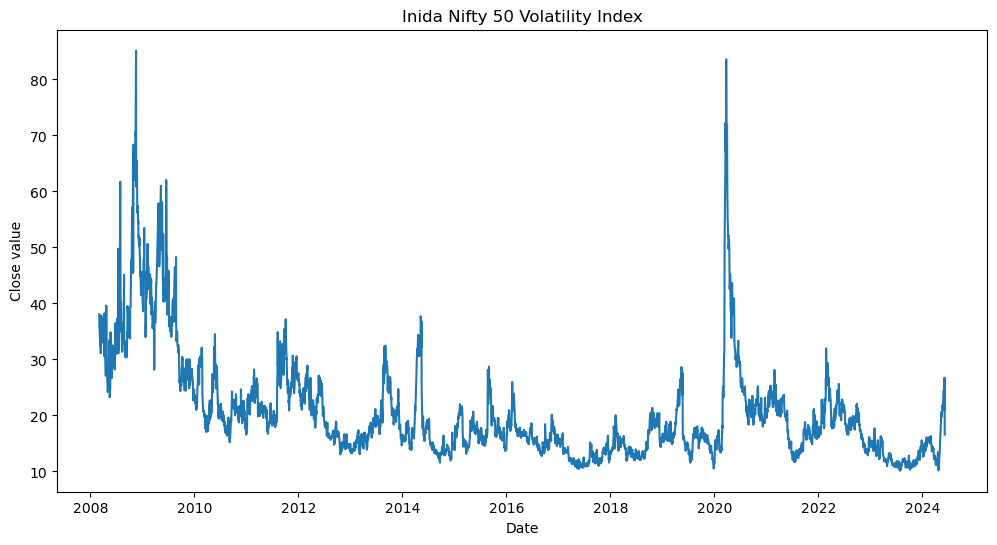

In [4]:
plt.figure(figsize=(12, 6))
# Create a line plot of the VIX close price
plt.plot(India.index, India['Price'])

# Set the title and axis labels
plt.title('Inida Nifty 50 Volatility Index')
plt.xlabel('Date')
plt.ylabel('Close value')

# Display the plot
plt.show()

#### Stationarity_check

In [5]:
India_close = India['Price'].dropna()

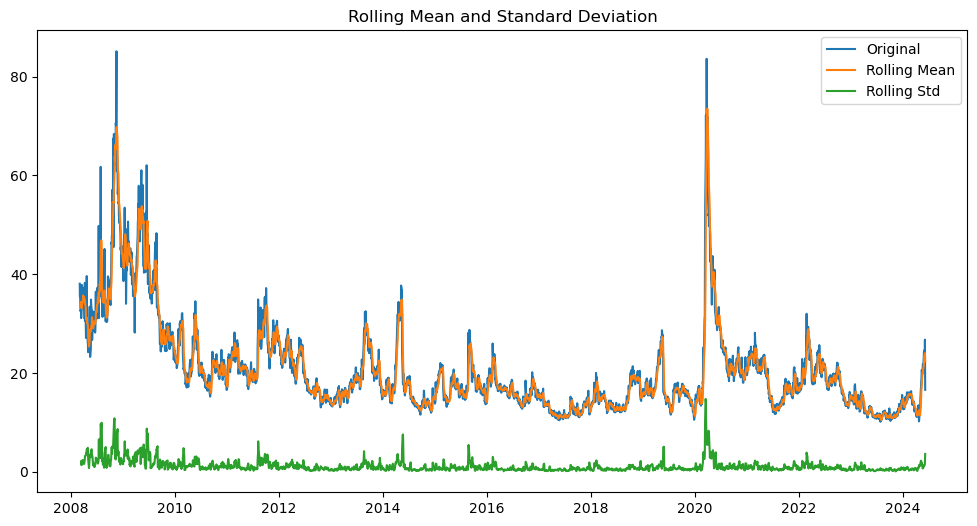

ADF Test Results:
ADF Statistic: -3.738408098835078
p-value: 0.0036042230739065486
Critical Values:
   1%: -3.4319887450134567
   5%: -2.862264107905561
   10%: -2.567155450408488
KPSS Test Results:
KPSS Statistic: 3.097921514004707
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16560\2208104654.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries, regression='c')


In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

# Plot rolling mean and standard deviation
def plot_rolling_statistics(timeseries, window=7):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

# Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print("ADF Test Results:")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(timeseries):
    result = kpss(timeseries, regression='c')
    print("KPSS Test Results:")
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')

# Check stationarity by plotting rolling statistics and conducting tests
plot_rolling_statistics(India['Price'])

adf_test(India_close)

kpss_test(India_close)


#### Performance_metrics

In [7]:
# Calculate performance metrics
def evaluation(test_data, model_predictions):
    mse = mean_squared_error(test_data, model_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, model_predictions)
    r2 = r2_score(test_data, model_predictions)

    print("Performance Metrics:")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R^2) Score:", r2)

## Build_Model

### Split_trainning_and_testing_dataset_using_VIX

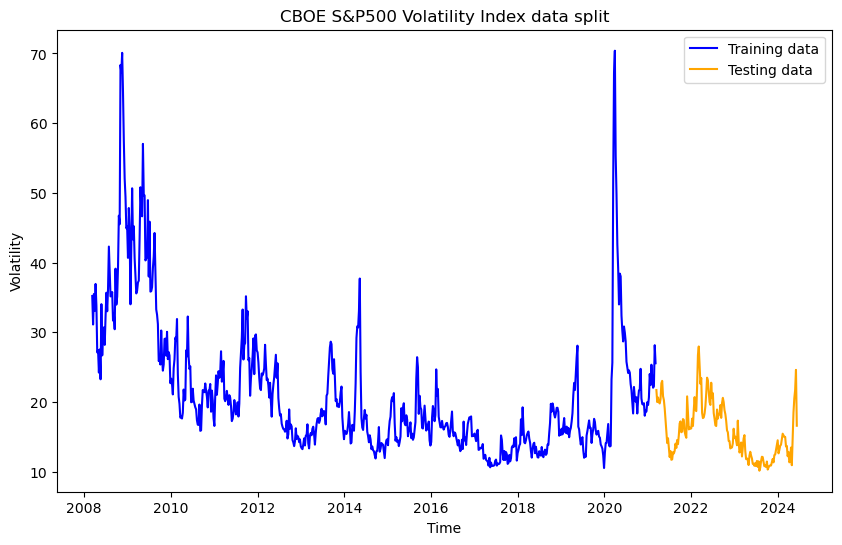

In [8]:
# Convert to the weekly dataset 
volatility_data = India['Price'].dropna().resample("W").last()

# Split the data into training, validation and test sets
train_size = int(len(volatility_data)*0.8)
test_size = len(volatility_data) - train_size

train_data = volatility_data[:train_size]
test_data = volatility_data[train_size:]
train_dates = train_data.index
test_dates = test_data.index

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(train_data, label="Training data", color="blue")
plt.plot(test_data, label="Testing data", color="orange")
plt.title("CBOE S&P500 Volatility Index data split")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Benchmark_Multi-Layer_Perceptron_(MLP)

In [9]:
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# Build the MLP model
model_mlp = Sequential()
model_mlp.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model_mlp.add(Dense(units=32, activation='relu'))
model_mlp.add(Dense(units=1))
model_mlp.compile(optimizer='adam', loss='mean_squared_error')

# Train the MLP model
model_mlp.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for MLP (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Make predictions on the test data
predicted_values_mlp = model_mlp.predict(X_test)
predicted_values_mlp = scaler.inverse_transform(predicted_values_mlp)


Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0588
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.0066
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.0067
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0045 
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0047
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.0030
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.0025
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.0031
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0023
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0030
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


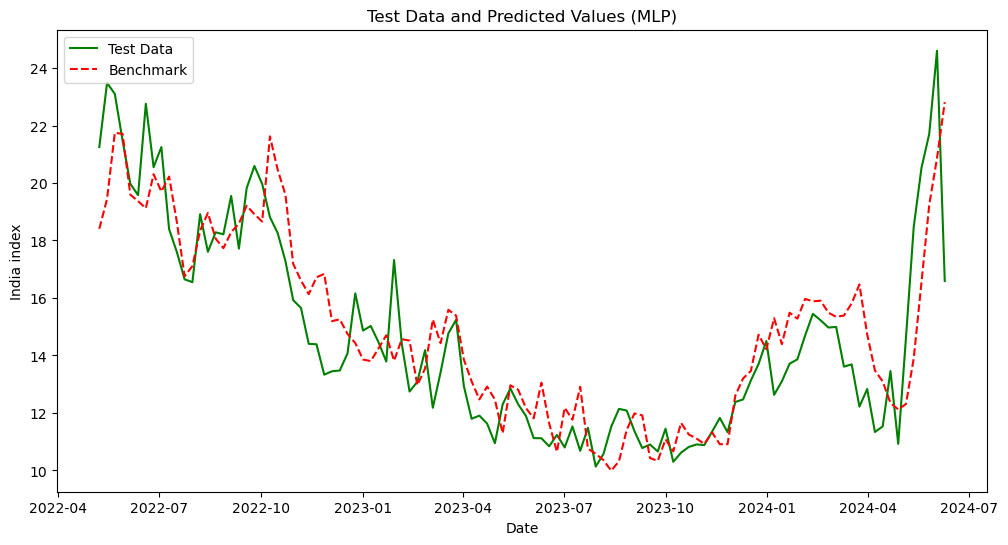

In [10]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='red', linestyle='dashed', label='Benchmark')
plt.title('Test Data and Predicted Values (MLP)')
plt.xlabel('Date')
plt.ylabel('India index')
plt.legend()
plt.show()

### Build_the_ARIMA_model_using_IV

Build a GARCH(1,1) model, and use the model to calculate fitted and predicted volatility of SP500 index. Plot the graph for original historical volatility and the predicted value, for the predicted value, use different color to show the fitted and predicted datasets.

In [11]:
# Train AutoARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3444.279, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3464.629, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3465.895, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3466.014, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3462.643, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3452.091, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3452.241, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3429.797, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3433.000, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3430.252, Time=0.69 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3429.302, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3431.098, Time=0.49 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3431.131, Time=0.84 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3430.943, Time=0.97 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

ARIMA(order=(5, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
history = [x for x in train_data]
predicted_values_arima = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16560\1009033278.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


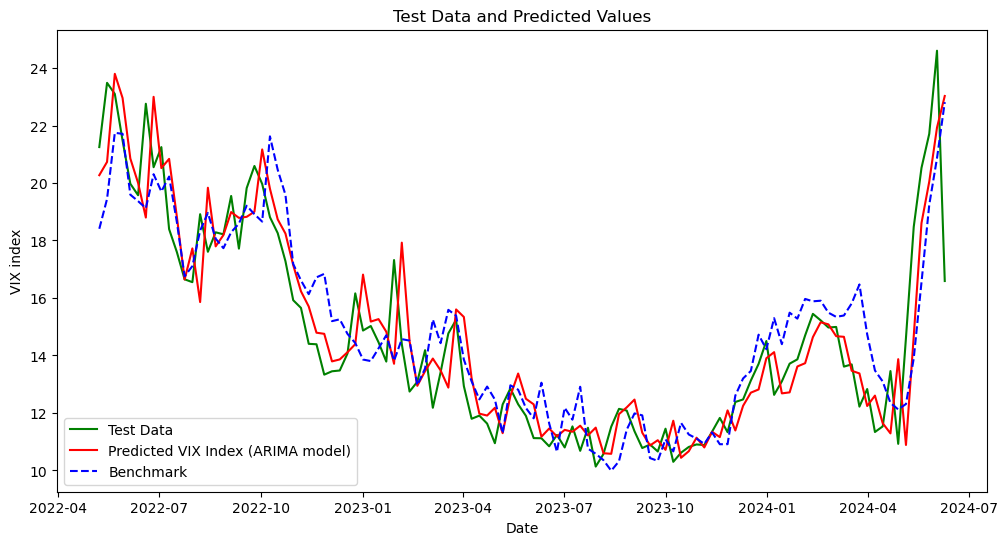

In [13]:
# Plot the graph
plt.figure(figsize=(12, 6))

# Plot the test data with a solid green line
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data', linestyle='-')

# Plot the predicted values from the ARIMA model with a dashed red line
plt.plot(test_dates[60:], predicted_values_arima[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA model)')

# Plot the predicted values from the MLP model with a dash-dot blue line
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values')
plt.xlabel('Date')
plt.ylabel('VIX index')

# Move the legend outside the plot area to avoid overlapping the lines
plt.legend()

plt.show()


In [14]:
evaluation(test_data, predicted_values_arima)

Performance Metrics:
Mean Squared Error (MSE): 2.724973928083439
Root Mean Squared Error (RMSE): 1.6507495049472038
Mean Absolute Error (MAE): 1.181898778574664
R-squared (R^2) Score: 0.8188366440477794


### Build_ANN_model_LSTM

In [ ]:
#Hyperparemeter tuning: grid search for hyperparameter tuning.

Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0124
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0074
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0083
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0054
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0104
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0062
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0068
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0299
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0087
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0081
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0099
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0129
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0057
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0118
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0060
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0078
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0060
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0218
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0057
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0053
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0043
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0038
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0034
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0039
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0146
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0088
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0094
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0073
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0089
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0062
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0048
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0059
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0042
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0248
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0126
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0076
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0058
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0051
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0092
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0113
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0039
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0053
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0063
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0203
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0059
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0051
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0037
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0037
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0035
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0036
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0263
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0122
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0084
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0060
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0062
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0041
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0024
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0024
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0020
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0023
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0450
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0088
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0079
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0049
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0053
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0052
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0029
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0277
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0073
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0033
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0045
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0030
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0028
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0031
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0024
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0023
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0022
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0954
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0081
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0053
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0046
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0080
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0059
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0030
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0038
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1228
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0127
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0095
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0052
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0050
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0049
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0046
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0038
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0027
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0042
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0379
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0078
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0045
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0041
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0031
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0032
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0027
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0024
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0022
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.0809
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7841
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3767
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0615
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0278
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0265
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0146
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0133
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0176
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0165
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 3.6311
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0272
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0311
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0272
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0223
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0229
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0191
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0253
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0215
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0262
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 7.1511
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0188
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0129
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0137
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0135
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0121
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0122
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0124
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0118
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0149
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 7.7967
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3735
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0689
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0144
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0120
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0137
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0085
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0144
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0135
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 10.8099
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0341
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0365
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0248
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0253
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0282
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0298
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0310
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0378
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0261
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 19.3952
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1967
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.3137
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.1796
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6162
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0368
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0171
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0165
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0144
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0145
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0197
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0103
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0121
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0085
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0075
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0090
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0081
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0058
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0062
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0052
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0036
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0065
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0339
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0104
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0053
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0077
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0065
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0079
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0067
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0049
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0052
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0063
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0072
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0083
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0079
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0204
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0053
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0051
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0044
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0045
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0038
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0043
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0033
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0121
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0070
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0060
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0051
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0059
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0041
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0042
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0026
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0060
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0041
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0027
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0040
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0025
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0022
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0026
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0174
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0138
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0106
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0073
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0067
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0043
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0071
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0047
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0052
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0040
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0050
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0043
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0042
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0039
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0032
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0249
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0088
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0051
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0043
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0039
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0037
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0044
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0040
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0038
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0032
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0039
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0040
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0034
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0035
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0034
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0280
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0069
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0049
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0038
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0016
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0036
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0020
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0019
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0015
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0020
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0019
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0019
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0017
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0358
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0069
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0058
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0058
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0037
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0053
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0026
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0020
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0028
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0018
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0268
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0070
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0052
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0036
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0034
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0025
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0028
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0027
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0022
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0231
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0099
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0068
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0023
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0028
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0019
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0023
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0016
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0683
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0109
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0066
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0074
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0058
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0048
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0050
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0053
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0041
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0024
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0022
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0022
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0022
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0265
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0067
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0059
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0037
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0023
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0023
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0015
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.1713
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0489
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0190
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0180
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0135
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0157
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0130
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0151
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0124
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0108
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0120
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0106
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0124
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0110
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0105
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.6080
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2105
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3436
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3739
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0498
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0254
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0216
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0198
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0208
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0191
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0195
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0239
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0157
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0191
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0196
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 3.4758
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0138
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0140
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0130
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0110
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0134
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0131
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0105
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0092
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0098
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0099
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0107
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0107
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0093
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0056
Epoch 16/20
13/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 20.0372
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2032
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1980
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0265
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0210
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0129
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0156
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0138
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0167
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0110
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0142
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0173
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0094
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0101
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0119
Epoch 16/20
13

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 19.2853
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.3934
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0898
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0350
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0235
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0189
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0226
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0223
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0189
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0261
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0192
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0222
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0251
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0260
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0215
Epoch 16/20
13

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 10.4083
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3380
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0166
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0144
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0222
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0153
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0107
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0115
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0124
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0101
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0123
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0111
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0076
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0146
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0111
Epoch 16/20
13

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0206
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0124
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0066
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0093
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0091
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0066
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0062
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0066
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0091
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0058
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0463
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0142
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0114
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0101
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0072
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0093
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0089
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0078
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0091
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0098
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0450
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0099
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0062
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0070
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0050
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0054
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0048
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0044
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0039
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0039
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0189
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0082
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0081
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0074
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0096
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0086
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0077
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0065
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0060
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0059
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0299
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0101
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0074
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0114
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0067
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0061
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0088
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0057
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0079
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0060
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0231
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0056
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0059
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0052
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0049
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0042
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0039
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0044
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0040
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0042
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0186
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0084
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0038
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0046
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0049
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0040
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0021
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0032
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0029
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0020
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0275
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0072
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0058
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0045
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0058
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0043
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0035
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0050
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0035
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0032
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0272
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0081
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0051
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0051
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0044
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0045
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0034
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0030
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0023
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0030
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0449
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0125
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0095
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0048
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0074
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0063
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0051
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0029
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0036
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0026
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0734
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0124
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0102
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0074
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0068
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0058
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0044
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0052
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0051
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0033
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0522
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0089
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0060
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0044
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0034
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0036
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0032
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0030
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0036
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0029
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 10.4840
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8715
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2463
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1196
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0573
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0370
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0265
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0274
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0222
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0130
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 3.2581
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0867
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0277
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0222
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0209
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0191
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0181
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0231
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0201
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0158
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 9.7547 
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1429
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1518
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0443
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0845
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0151
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0110
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0123
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0106
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0115
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 12.9569
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.4072
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.5643
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2272
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1828
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0754
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0391
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0294
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0230
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0162
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 22.7069
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.1179
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1496
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0862
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0518
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0243
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0290
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0214
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0228
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0244
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.9748
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2307
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0348
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0185
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0153
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0155
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0156
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0132
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0129
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0129
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0195
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0099
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0100
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0077
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0066
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0053
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0075
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0053
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0050
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0054
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0045
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0066
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0051
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0060
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0053
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0380
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0139
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0118
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0088
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0072
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0090
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0092
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0062
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0067
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0073
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0074
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0056
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0055
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0076
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0082
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0230
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0094
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0059
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0047
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0047
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0047
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0043
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0038
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0044
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0039
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0043
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0039
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0040
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0038
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0147
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0091
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0078
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0075
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0057
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0082
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0045
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0063
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0044
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0048
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0055
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0043
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0044
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0043
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0060
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0419
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0097
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0112
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0088
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0076
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0093
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0081
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0082
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0087
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0081
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0046
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0101
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0053
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0047
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0058
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0273
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0062
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0048
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0054
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0041
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0041
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0043
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0038
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0036
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0038
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0042
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0035
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0036
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0037
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0039
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0497
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0112
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0057
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0080
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0044
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0069
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0049
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0033
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0045
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0039
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0028
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0025
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0036
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0028
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0396
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0088
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0076
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0073
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0058
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0061
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0040
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0044
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0038
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0044
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0027
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0027
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0023
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0020
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0270
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0062
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0049
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0045
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0032
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0028
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0026
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0025
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0026
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0022
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0022
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0021
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0020
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.1106
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0133
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0144
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0091
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0092
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0083
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0045
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0072
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0046
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0043
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0039
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0032
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0037
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0050
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0023
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0603
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0109
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0110
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0074
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0083
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0048
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0045
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0086
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0047
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0030
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0029
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0040
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0031
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0025
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0031
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1111
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0101
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0055
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0041
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0036
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0041
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0035
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0038
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0034
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0038
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0032
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0029
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0033
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0038
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0031
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 8.1138
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3150
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2000
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1488
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0872
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0376
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0242
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0214
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0187
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0166
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0134
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0188
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0166
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0168
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0131
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 11.0414
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5921
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2216
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0619
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0435
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0432
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0336
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0303
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0223
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0222
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0225
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0225
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0191
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0197
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0206
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 14.8862
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1369
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0404
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0297
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0178
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0172
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0139
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0130
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0158
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0139
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0139
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0130
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0129
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0129
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0124
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 12.3664
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2160
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0227
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0836
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5156
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0848
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1943
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1035
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0256
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0348
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0207
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0209
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0151
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0216
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0171
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 24.1045
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0977
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0340
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0309
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0343
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0225
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0204
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0213
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0198
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0244
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0199
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0223
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0212
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0190
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0193
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 21.7457
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.4583
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3764
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0797
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0294
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0226
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0238
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0145
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0120
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0134
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0130
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0133
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0161
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0128
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0156
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0209
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0061
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0049
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0031
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0020
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0018
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0020
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017
Epoch 16/20
20/

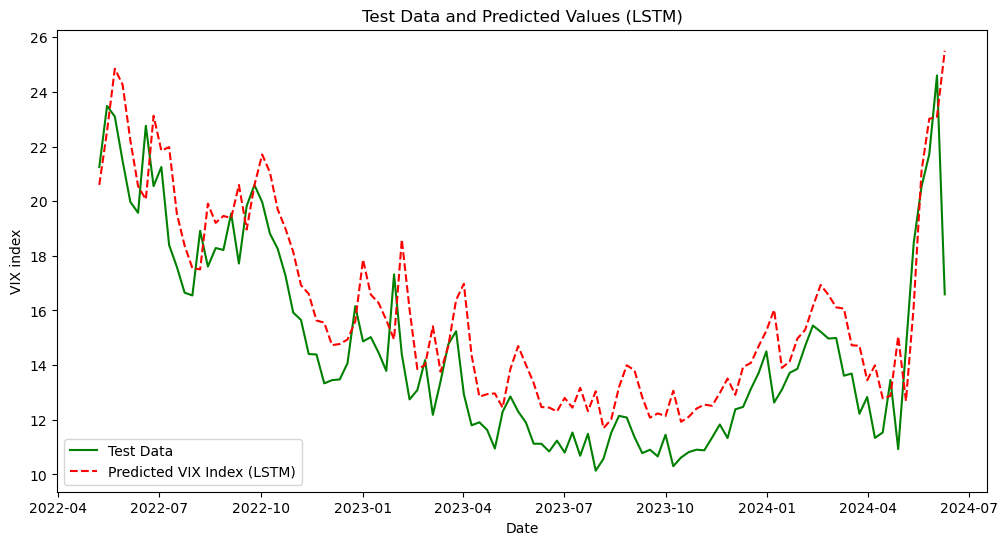

In [15]:
# Normalize the data
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_normalized, lookback)
X_test, y_test = create_sequences(test_data_normalized, lookback)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model as a scikit-learn estimator
regressor = KerasRegressor(model=create_lstm_model, units=50, learning_rate=0.001)

# Perform hyperparameter tuning using grid search
param_grid = {
    'model__units': [50, 100], 
    'batch_size': [32, 64], 
    'epochs': [10, 20], 
    'model__learning_rate': [0.001, 0.01, 0.1]
}
model = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3)
model.fit(X_train, y_train)

# Get the best hyperparameters
best_units = model.best_params_['model__units']
best_batch_size = model.best_params_['batch_size']
best_epochs = model.best_params_['epochs']
best_learning_rate = model.best_params_['model__learning_rate']

print(f"Best Hyperparameters: units={best_units}, batch_size={best_batch_size}, epochs={best_epochs}, learning_rate={best_learning_rate}")

# Train the LSTM model with the best hyperparameters
final_model = create_lstm_model(units=best_units, learning_rate=best_learning_rate)
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Make predictions on the test data
predicted_values_lstm = final_model.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='dashed', label='Predicted VIX Index (LSTM)')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()



In [26]:
#Best Hyperparameters: units=50, batch_size=32, epochs=20, learning_rate=0.01

In [16]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm = model_lstm.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0221
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0084
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0049
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0054
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0062
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0051
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0045
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0047
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0048
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0049
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0057
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0036
Epoch 16/20
20/

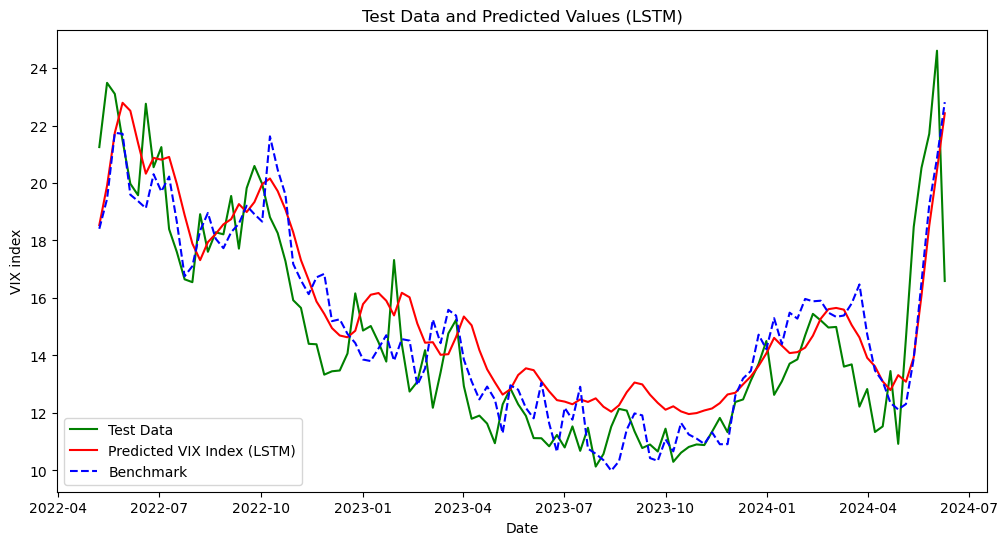

In [17]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='-', label='Predicted VIX Index (LSTM)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [18]:
evaluation(test_data[lookback:], predicted_values_lstm)

Performance Metrics:
Mean Squared Error (MSE): 3.332727227455781
Root Mean Squared Error (RMSE): 1.8255758618736668
Mean Absolute Error (MAE): 1.506105010292747
R-squared (R^2) Score: 0.734824113712042


In [19]:
evaluation(test_data[lookback:], predicted_values_mlp)

Performance Metrics:
Mean Squared Error (MSE): 2.9826301102786577
Root Mean Squared Error (RMSE): 1.7270292731388943
Mean Absolute Error (MAE): 1.3043590074018998
R-squared (R^2) Score: 0.7626803728650526


### Build_ANN_model_GRU

In [20]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru = model_gru.predict(X_test)
predicted_values_gru = scaler.inverse_transform(predicted_values_gru)


Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0129
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0037
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0037
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0026
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0024
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0025
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0019
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0023
Epoch 16/20
20/

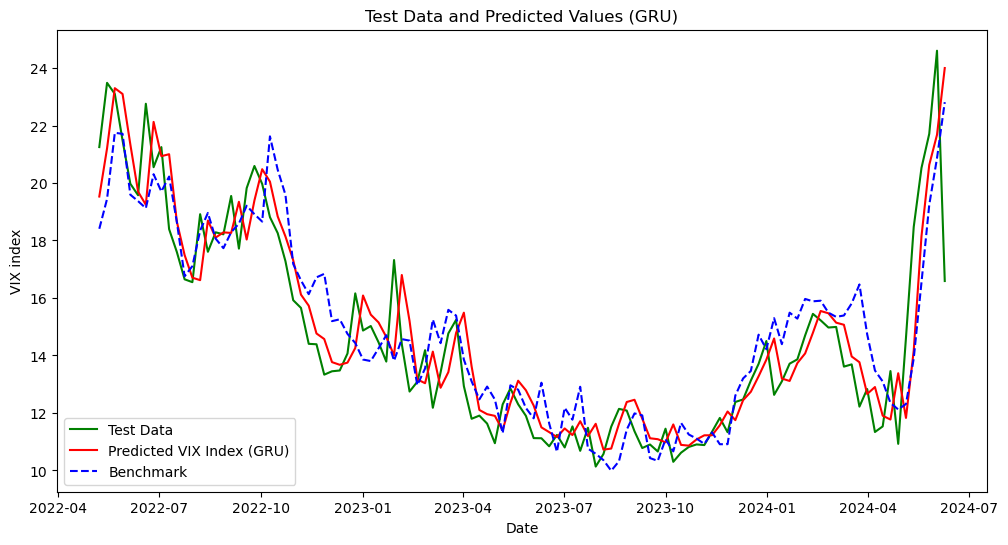

In [21]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru, color='red', linestyle='-', label='Predicted VIX Index (GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [22]:
evaluation(test_data[lookback:], predicted_values_gru)

Performance Metrics:
Mean Squared Error (MSE): 2.195653301336394
Root Mean Squared Error (RMSE): 1.4817737011218663
Mean Absolute Error (MAE): 1.046246289686723
R-squared (R^2) Score: 0.8252979405675995


### Build_LSTM-ARIMA_model

In [23]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm_arima = scaler.inverse_transform(model_lstm.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0728
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0224
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0257
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0187
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0183
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0210
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0138
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0145
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0164
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0131
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0159
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0141
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0142
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0149
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0131
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/

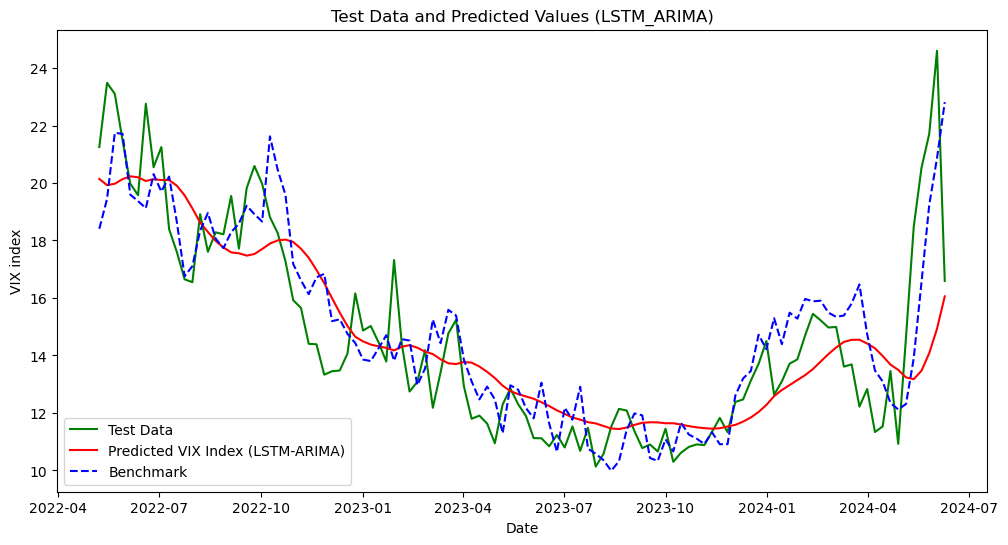

In [24]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm_arima, color='red', linestyle='-', label='Predicted VIX Index (LSTM-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (LSTM_ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()


In [25]:
evaluation(test_data[lookback:], predicted_values_lstm_arima)

Performance Metrics:
Mean Squared Error (MSE): 4.304523355275356
Root Mean Squared Error (RMSE): 2.0747345264576276
Mean Absolute Error (MAE): 1.4527832211581144
R-squared (R^2) Score: 0.6575009840653088


### Build_ARIMA-LSTM_model

In [26]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_lstm]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=151.392, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=222.900, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=150.315, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=169.171, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=221.218, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=147.921, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=149.402, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=149.467, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=148.835, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=151.315, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=146.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=148.799, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=147.642, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=147.118, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=147.2

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [27]:
#One_step ahead forecast
predicted_values_arima_lstm = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_lstm.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16560\188375866.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


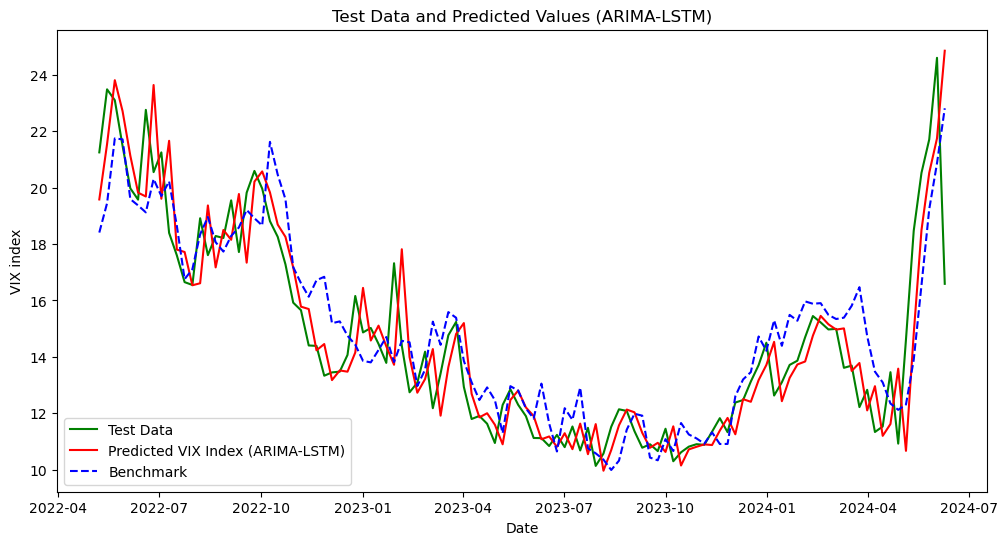

In [28]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_lstm[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-LSTM)')
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (ARIMA-LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [29]:
evaluation(test_data, predicted_values_arima_lstm)

Performance Metrics:
Mean Squared Error (MSE): 2.8757473704149423
Root Mean Squared Error (RMSE): 1.6958028689723763
Mean Absolute Error (MAE): 1.2232666904594673
R-squared (R^2) Score: 0.8088128333537612


### Build_GRU-ARIMA_model

In [30]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru_arima = scaler.inverse_transform(model_gru.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0738
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0177
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0257
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0211
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0155
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0140
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0133
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0121
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0119
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0131
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0123
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0112
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0095
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0121
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0102
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/

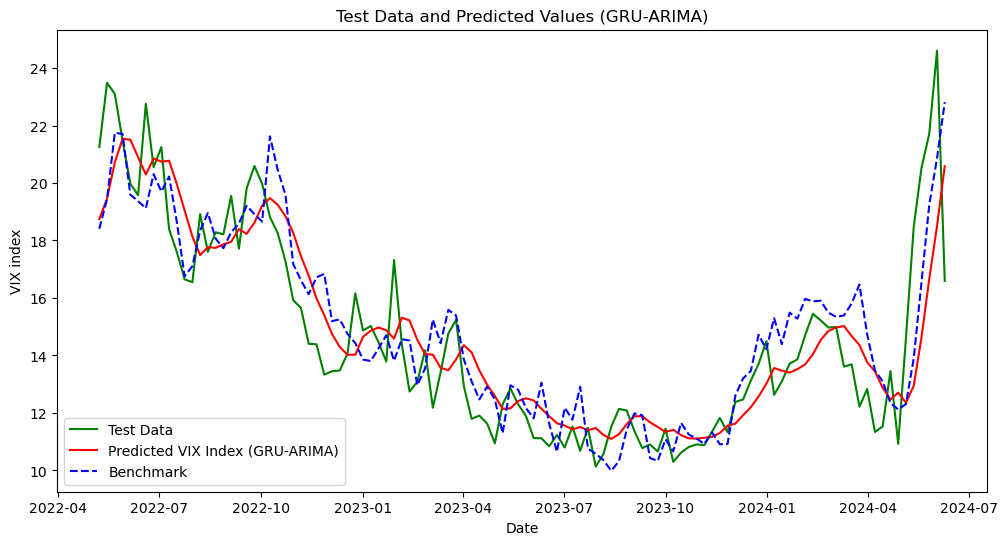

In [31]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru_arima, color='red', linestyle='-', label='Predicted VIX Index (GRU-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (GRU-ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
#plt.grid(True)
plt.show()

In [32]:
print(len(test_data))

170


In [33]:
print(len(predicted_values_gru_arima))

110


In [ ]:
evaluation(test_data, predicted_values_gru_arima)

### Build_ARIMA-GRU_model

In [35]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_gru]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=335.409, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=333.517, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=333.513, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=333.558, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=335.469, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=335.458, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=337.350, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=331.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=333.615, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=333.603, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=331.665, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=335.494, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.493 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [42]:
#One_step ahead forecast
predicted_values_arima_gru = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_gru.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16560\3204628026.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


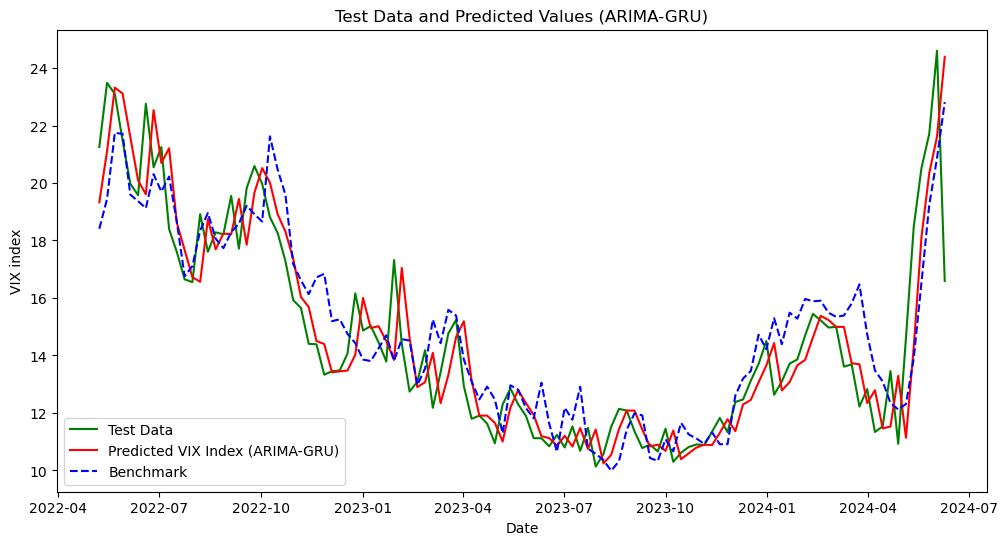

In [43]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_gru[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (ARIMA-GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [44]:
evaluation(test_data, predicted_values_arima_gru)

Performance Metrics:
Mean Squared Error (MSE): 2.72971090761782
Root Mean Squared Error (RMSE): 1.6521836785351136
Mean Absolute Error (MAE): 1.1741566202538283
R-squared (R^2) Score: 0.8185217173247451


## Strategies

### Combine_models_prediction_results

In [45]:
y_lstm = pd.Series([x[0] for x in predicted_values_lstm], index = test_dates[60:])
y_lstm_arima = pd.Series([x[0] for x in predicted_values_lstm_arima], index = test_dates[60:])
y_arima_lstm = pd.Series(predicted_values_arima_lstm[60:],index =test_dates[60:])
y_gru = pd.Series([x[0] for x in predicted_values_gru], index = test_dates[60:])
y_gru_arima = pd.Series([x[0] for x in predicted_values_gru_arima], index = test_dates[60:])
y_arima_gru = pd.Series(predicted_values_arima_gru[60:],index =test_dates[60:])
y_benchmark = pd.Series([x[0] for x in predicted_values_mlp], index = test_dates[60:])
y_test = test_data[60:]

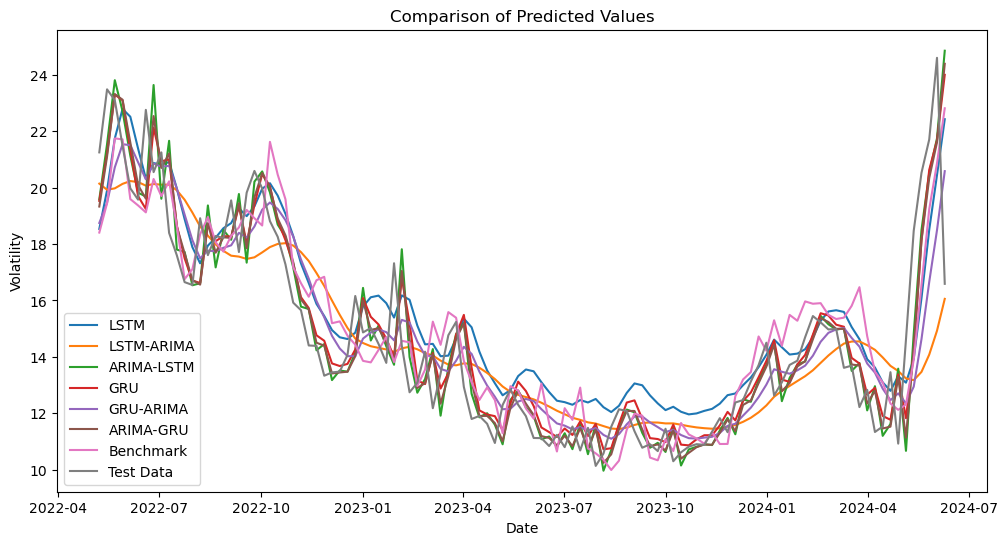

In [46]:
plt.figure(figsize=(12, 6))
# Plot the y-values
plt.plot(y_lstm, label='LSTM')
plt.plot(y_lstm_arima, label='LSTM-ARIMA')
plt.plot(y_arima_lstm, label='ARIMA-LSTM')
plt.plot(y_gru, label='GRU')
plt.plot(y_gru_arima, label='GRU-ARIMA')
plt.plot(y_arima_gru, label='ARIMA-GRU')
plt.plot(y_benchmark, label='Benchmark')
plt.plot(y_test, label='Test Data')

# Set the title and labels
plt.title('Comparison of Predicted Values')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# Display the plot
plt.show()

In [47]:
models = ["Benchmark",'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU',"Test_data"]
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru,y_test]

data_vol = {model: prediction for model, prediction in zip(models, predictions)}

# Create the DataFrame
df_vol = pd.DataFrame(data_vol)

In [48]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2022-05-08,18.407360,18.536249,20.142416,19.581124,19.529526,18.747236,19.330171,21.2500
2022-05-15,19.446375,19.903776,19.924477,21.541494,21.206532,19.460428,21.106473,23.4850
2022-05-22,21.746305,21.745169,19.975437,23.809894,23.299454,20.720097,23.316977,23.1000
2022-05-29,21.711262,22.790752,20.134178,22.712068,23.097418,21.538317,23.115396,21.4800
2022-06-05,19.593637,22.512981,20.233591,21.132479,21.344475,21.508045,21.596570,19.9750
...,...,...,...,...,...,...,...,...
2024-05-12,13.896930,13.934501,13.175360,14.820627,14.172597,12.943686,14.288565,18.4725
2024-05-19,16.542086,16.081848,13.468136,18.495800,18.147625,14.629347,18.121459,20.5250
2024-05-26,19.239449,18.514069,14.081709,20.527807,20.631296,16.659409,20.343019,21.7100


### Evaluation_method_index_metrics

In [49]:
#Evaluation method 1: index metrics (Prediction accuracy) Ref: Main1
#1 Testing accuracy ratio for modelling (bar plot/box plot)
#2 MSE, RMSE, MAE, etc...

In [54]:
# Calculate statistical measures for each model
metrics = ['MSE', 'RMSE', 'MAE', 'Correlation', 'Cosine Similarity', 'R-squared']
results = []

for column in df_vol.columns[:-1]:  # Exclude the 'Test_data' column
    model_data = df_vol[column]
    test_data = df_vol['Test_data']
    
    # Calculate statistical measures
    mse = np.mean((model_data - test_data) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(model_data - test_data))
    correlation = np.corrcoef(model_data, test_data)[0, 1]
    cosine_similarity = np.dot(model_data, test_data) / (np.linalg.norm(model_data) * np.linalg.norm(test_data))
    
    # Calculate R-squared
    ss_res = np.sum((test_data - model_data) ** 2)
    ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Store the results
    results.append([mse, rmse, mae, correlation, cosine_similarity, r_squared])

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=metrics, index=df_vol.columns[:-1])

# Sort the models based on the similarity metrics (choose the desired metric as per your preference)
df_results_sorted_vol = df_results.sort_values(by='MSE', ascending=True)

In [55]:
df_results_sorted_vol

,MSE,RMSE,MAE,Correlation,Cosine Similarity,R-squared
GRU,2.195653,1.481774,1.046246,0.911213,0.995265,0.825298
ARIMA_GRU,2.295356,1.515043,1.060641,0.908611,0.994959,0.817365
ARIMA_LSTM,2.485917,1.576679,1.095411,0.902780,0.994549,0.802202
Benchmark,2.982630,1.727029,1.304359,0.877130,0.993603,0.762680
GRU_ARIMA,3.041535,1.744000,1.286388,0.870966,0.993298,0.757993
LSTM,3.332727,1.825576,1.506105,0.886901,0.993823,0.734824
LSTM_ARIMA,4.304523,2.074735,1.452783,0.811380,0.990494,0.657501


In [56]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2022-05-08,18.407360,18.536249,20.142416,19.581124,19.529526,18.747236,19.330171,21.2500
2022-05-15,19.446375,19.903776,19.924477,21.541494,21.206532,19.460428,21.106473,23.4850
2022-05-22,21.746305,21.745169,19.975437,23.809894,23.299454,20.720097,23.316977,23.1000
2022-05-29,21.711262,22.790752,20.134178,22.712068,23.097418,21.538317,23.115396,21.4800
2022-06-05,19.593637,22.512981,20.233591,21.132479,21.344475,21.508045,21.596570,19.9750
...,...,...,...,...,...,...,...,...
2024-05-12,13.896930,13.934501,13.175360,14.820627,14.172597,12.943686,14.288565,18.4725
2024-05-19,16.542086,16.081848,13.468136,18.495800,18.147625,14.629347,18.121459,20.5250
2024-05-26,19.239449,18.514069,14.081709,20.527807,20.631296,16.659409,20.343019,21.7100


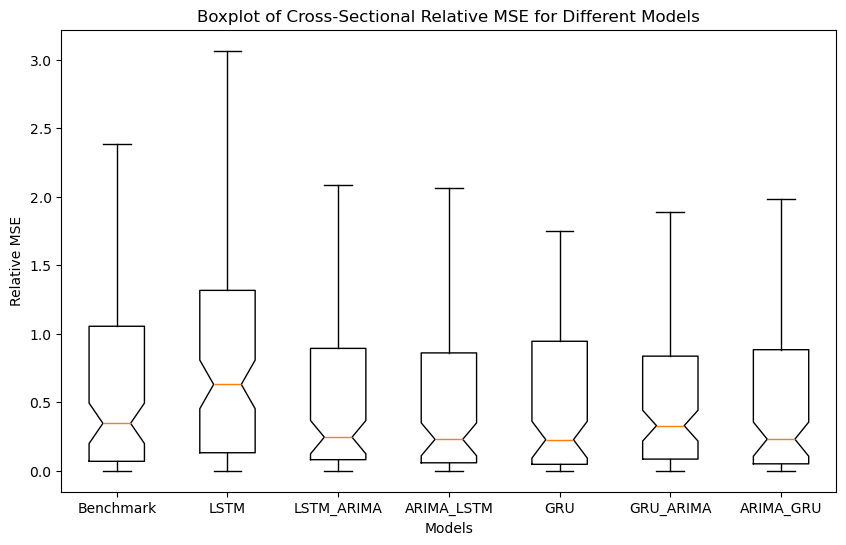

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate relative MSE for each model
models = df_vol.columns[:-1]  # Extract the model names from df_vol
relative_mse_values = []

for model in models:
    mse_values = (df_vol['Test_data'] - df_vol[model]) ** 2
    relative_mse = mse_values / np.mean(mse_values)
    relative_mse_values.append(relative_mse)

# Create boxplots of relative MSE for different models
plt.figure(figsize=(10, 6))
plt.boxplot(relative_mse_values, vert=True, showfliers=False, notch=True, labels=models)
plt.xlabel('Models')
plt.ylabel('Relative MSE')
plt.title('Boxplot of Cross-Sectional Relative MSE for Different Models')
plt.show()
